# Angelo

Notebook iterating gamma. I use this to generate experimental phases used for the analysis.

### Imports

In [1]:
from XRDXRFutils import Phase,DatabaseXRD, DataXRD, SpectraXRD, GaussNewton, PhaseList, PhaseMap, PhaseSearch, PhaseMapSave
from XRDXRFutils import GammaMap,ChiMap

import os
import pickle


from joblib import Parallel, delayed
import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace,concatenate,sqrt,log,histogram,array,unravel_index
from matplotlib.pyplot import sca,vlines,show,fill_between,sca,legend,imshow,subplots,plot,xlim,ylim,xlabel,ylabel,cm,title,scatter,colorbar,figure,vlines
from sklearn.cluster import KMeans,MiniBatchKMeans

from multiprocessing import Pool

from PIL import Image

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

#### Define Paths and Spectra Parameters

In [2]:
path_xrd = '/home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/' # XRD scan
path_xrf = '/home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRF/' # XRF scan
path_database = '/home/shared/DatabaseXRD'

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

min_theta = 20
max_theta = 58
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)

sigma = 0.2

## Read XRD Data

from xrd.h5

Loading: /home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/xrd.h5
a: -1172.8 s: 2053.1 beta: 50.710


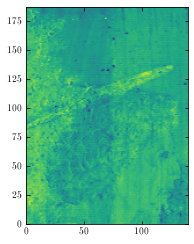

In [3]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background().save_h5(path_xrd + 'xrd.h5')
    
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

figure(figsize=(6,4))
im = imshow(data.data.sum(axis=2))
show()

## Read database

##### Define Phases
This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [4]:
database = DatabaseXRD().read_cifs(path_database)

print('Phases in database:',len(database))

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]
gold = database['Gold'][0]

huntite = database['Huntite'][0]
as4 = database['As4 O6'][0]

orpiment = database['Orpiment'][0]
cuprorivaite = database['Cuprorivaite'][0]

phases_a_s = PhaseList([hydrocerussite, cinnabar, lazurite, gold, hematite])

phases_a_s.get_theta(min_intensity=min_intensity,
                 min_theta = min_theta,
                 max_theta = max_theta,
                first_n_peaks = first_n_peaks)

if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s

Phases in database: 137


PhaseMap construct a data structures for the minimization.

In [5]:
%%time
pm = GammaMap().from_data(data,phases_a_s,sigma = sigma)

CPU times: user 2.19 s, sys: 181 ms, total: 2.37 s
Wall time: 2.36 s


### Autocalibration and Search
Iterates $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [23]:
%%time
pm = pm.search()

CPU times: user 29.6 s, sys: 9.05 s, total: 38.7 s
Wall time: 50.4 s


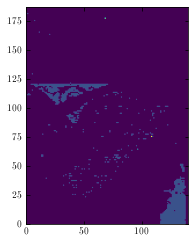

In [24]:
map_selected = pm.selected()
imshow(map_selected[...,0])
show()

In [25]:
%%time
L1loss,MSEloss,overlap_area = pm.metrics()

CPU times: user 3.82 s, sys: 2.2 s, total: 6.02 s
Wall time: 7.57 s


### Histogram of $a$

If $a$ is spead over too large area it might be that the phases are to right or a phase is missing

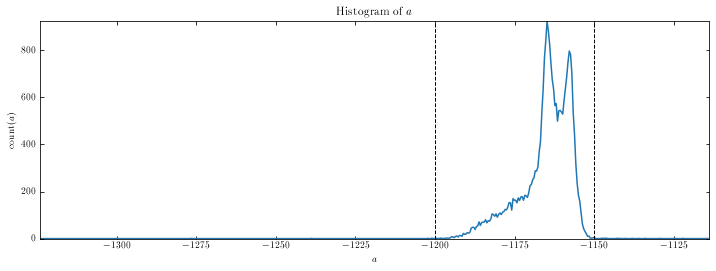

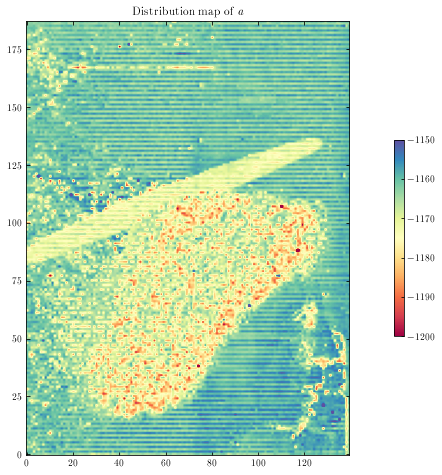

In [26]:
%matplotlib inline

opt = pm.opt()
a = opt[...,0]
s = opt[...,1]

vmin = -1200
vmax = -1150

h,b = histogram(a,bins=512)

figure(figsize=(12,4))

plot(b[:-1],h)
xlim(b[0],b[-1])
ylim(0,h.max())

vlines(vmin,0,h.max(),'k',ls='--',lw=1)
vlines(vmax,0,h.max(),'k',ls='--',lw=1)

xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

figure(figsize=(16,8))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im,fraction=0.011)

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $as$ dependence but it is weak.

Linear: [   -2.8939739 -1314.4202855]
Cauchy: [   -3.05572774 -1500.13736862]
mean a,s: -1165.0225835677406 2057.1246659503136
most probable a,s: -1164.811147273745 2059.208363144602


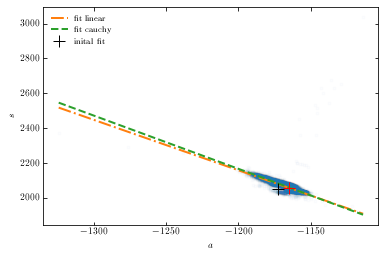

In [27]:
%matplotlib inline

opt,var = curve_fit(f_linear,a.flatten(),s.flatten())
res = least_squares(f_loss,x0=opt,args=(a.flatten(),s.flatten()),loss='cauchy')

linear_y = f_linear(a.flatten(),*opt)
cauchy_y = f_linear(a.flatten(),*res['x'])

print('Linear:',opt)
print('Cauchy:',res['x'])

plot(a.flatten(),s.flatten(),'.',alpha=0.01)

x = linspace(a.min(),a.max(),10)
plot(x,f_linear(x,*opt),'-.',lw=2,label='fit linear')
plot(x,f_linear(x,*res['x']),'--',lw=2,label='fit cauchy')
plot(data.opt[0],data.opt[1],'k+',ms=12,label='inital fit')

print('mean a,s:',a.mean(),s.mean())

legend(frameon=False)

xlabel(r'$a$')
ylabel(r'$s$')

pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])

print('most probable a,s:',pmax_a,pmax_s)

plot(pmax_a,pmax_s,'r+',ms=12,label='most likely')

show()

### Criterium

Criterium for phase selection.

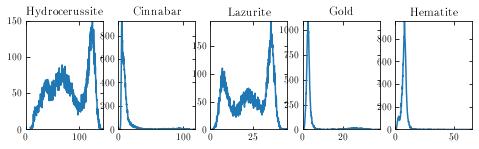

In [28]:
fig,ax = subplots(1,len(pm.phases),figsize=(8,2))

criterium = overlap_area * data.rescaling**0.5

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(criterium[:,:,i],bins=512)
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,b.max())
    ax[i].set_ylim(0,h.max())
    
show()

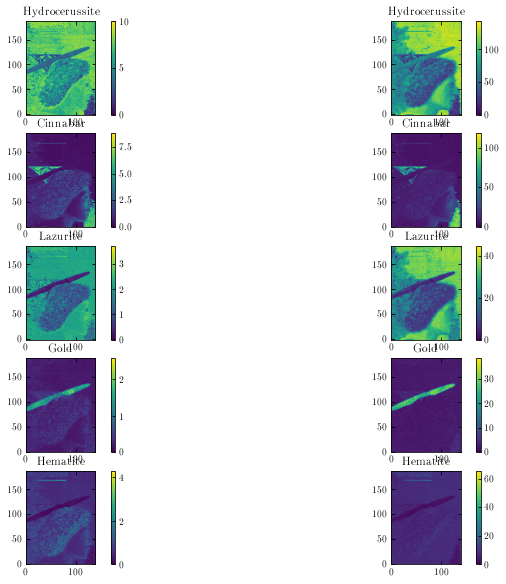

In [54]:
%matplotlib inline
fig,ax = subplots(len(pm.phases),2,figsize=(12,10))

for i,phase in enumerate(pm.phases):
    ax[i,0].set_title(phase.label)
    p = ax[i,0].imshow(overlap_area[...,i],vmin=0)
    colorbar(p,ax = ax[i,0])
    
    ax[i,1].set_title(phase.label)
    p = ax[i,1].imshow(criterium[...,i],vmin=0)
    colorbar(p,ax = ax[i,1])
show()

In [80]:
new_phases = pm.select_phases(criterium,-16)
for phase in new_phases:
    name = 'AngeloDatabase/' + phase.label + '.cif'
    print(name)
    phase.save_cif(name)

AngeloDatabase/Hydrocerussite.cif
AngeloDatabase/Cinnabar.cif
AngeloDatabase/Lazurite.cif
AngeloDatabase/Gold.cif
AngeloDatabase/Hematite.cif


In [81]:
experimental_phases = PhaseList(new_phases)

24402 (174, 42)
Hydrocerussite [-1165.10890318  2042.63365904    50.71024216]
1389 (9, 129)
Cinnabar [-1162.31918183  2036.86655669    50.71024216]
24193 (172, 113)
Lazurite [-1113.66062612  1872.5326145     50.71024216]
17027 (121, 87)
Gold [-1150.43835671  2008.67454374    50.71024216]
23449 (167, 69)
Hematite [-1172.90601661  2046.51312848    50.71024216]


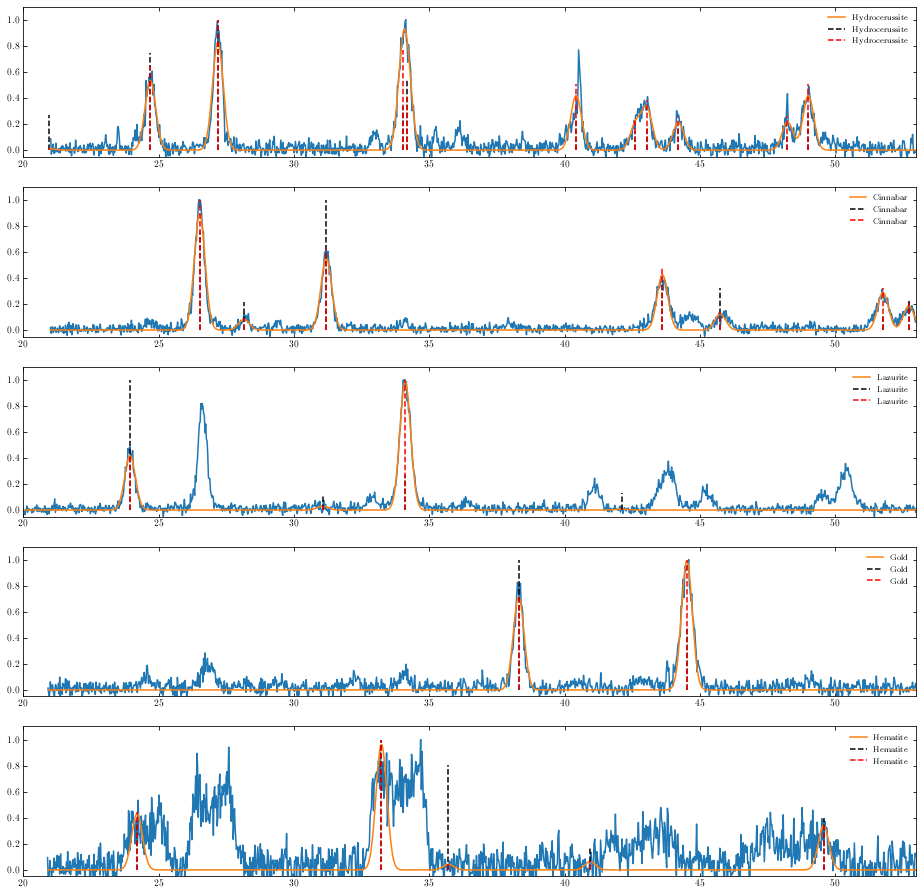

In [82]:
fig, ax = subplots(len(pm.phases),1,figsize=(16,16))

for idx,phase in enumerate(new_phases):
    point = phase['point']
    print(point,unravel_index(point,pm.shape[:2]))

    sca(ax[idx])
    
    g = pm[point][idx]
    g.fit_cycle(gamma=True,steps = 128,a=True,s=True)
    print(g.label,g.opt)
    
    g.plot_spectrum()
    g.plot(label=g.label)
    
    g.phase.plot('k')
    phase.plot('r')
    
    xlim(20,53)
    ylim(-0.05,1.1)
    legend(frameon=False)

show()

## Check single pixel

[-1172.7735954   2053.10153746    50.71024216]


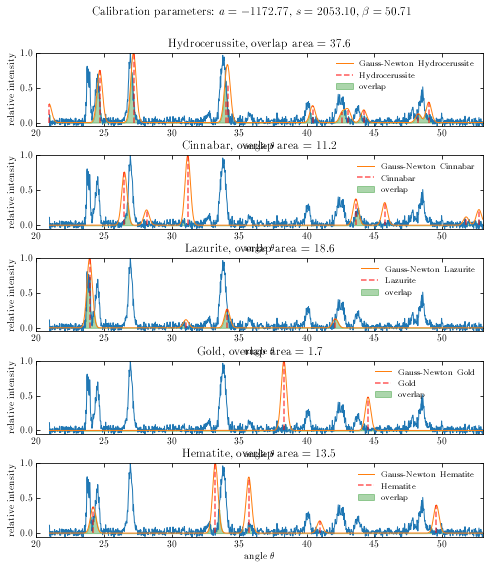

In [15]:
%matplotlib inline
selected = pm.get_pixel(34,187)

fig, axes = subplots(len(selected), 1, figsize = (8,8))
fig.subplots_adjust(hspace = 0.4, bottom = 0.06, top = 0.9)
print(selected.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(selected.opt[0], selected.opt[1], selected.opt[2]))

for i in range(len(selected)):
    ax = axes[i]
    g = selected[i]
    sca(ax)

    ax.set_title(f'{g.label}, overlap area = {g.overlap_area():.1f}')
    g.plot_spectra(lw = 1)
    g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
    g.phase.plot('r', alpha=0.66)

    fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')

    legend(frameon = False)
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(20, 53)
    ax.set_xlabel(r'angle $\theta$')
    ax.set_ylabel(r'relative intensity')
    
show()

[-1153.61142479  2028.46226357    50.71024216]
[[0.5290142  0.29973987 0.         0.00283836 0.01458569 0.69064352
  0.80644277 1.40024441 0.88328293 1.00007609 1.16415314 1.70392936
  1.08629912 1.15378192 1.34539556 0.3485723 ]] [21.08282019 21.10416762 21.12552408 ... 54.19117671 54.21931766
 54.24745691]


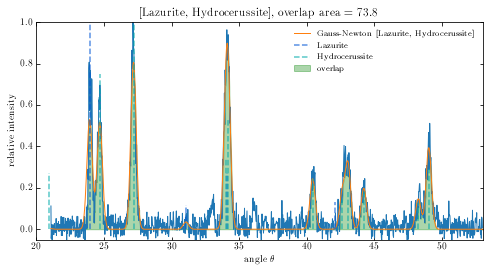

In [16]:
mix = PhaseList([lazurite,hydrocerussite])

g = GaussNewton(mix,selected.spectrum,sigma=sigma)

g.fit_cycle(gamma=True,steps = 128,a=True,s=True)

print(g.opt)
print(g.gamma,g.theta)

figure(figsize=(8,4))

title(f'{g.label}, overlap area = {g.overlap_area():.1f}')

g.plot_spectra(lw = 1)
g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
g.phase.plot(alpha=0.66)

fill_between(g.theta, g.overlap(), color = 'g', alpha = 0.33, label='overlap')

legend(frameon = False)

ylim(-0.05, 1)
xlim(20, 53)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

show()

In [11]:
g.make_phase().save_cif('AngeloDatabase/mix.cif')

### Fit errrors

Plotting the histograms and maps of the error for each phase. 

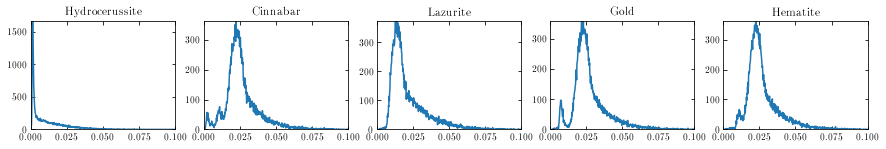

In [39]:
fig,ax = subplots(1,len(pm.phases),figsize=(15,2))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(MSEloss[:,:,i],bins=512,range=(0,0.1))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,b.max())
    ax[i].set_ylim(0,h.max())
    
show()

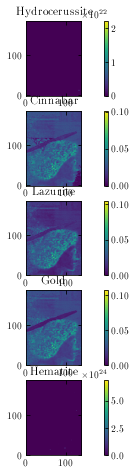

In [40]:
fig,ax = subplots(len(pm.phases),1,figsize=(8,8))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(MSEloss[:,:,i],vmin=0)
    p = colorbar(p,ax = ax[i],fraction=0.04)
    
show()